In [14]:
import json
from os.path import exists
import random
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.notebook import trange, tqdm

from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_mean_width_score

In [15]:
from data_generation import create_artificial_data
data = create_artificial_data(20, 5)

In [16]:
data.head()

,X_ 0,X_ 1,X_ 2,X_ 3,X_ 4,X_ 5,X_ 6,X_ 7,X_ 8,X_ 9,...,X_ 11,X_ 12,X_ 13,X_ 14,X_ 15,X_ 16,X_ 17,X_ 18,X_ 19,Class
0,9.330354,2.428477,5.614626,0.850115,-10.185019,2.257726,-6.114606,-3.708387,-1.871708,-2.488929,...,-1.243033,-1.322740,2.429695,-0.710730,0.305837,0.253141,0.588985,-0.877915,2.604924,4
1,-24.295108,2.638299,10.485304,1.721681,-2.706266,-10.688367,5.493782,-0.801968,-0.564715,5.449443,...,3.383613,8.896676,6.406975,0.332717,-0.667878,-6.546149,0.675696,-4.982589,-10.373572,3
2,-0.363166,3.545141,-3.465557,1.386227,-4.111342,-2.357812,4.098716,1.529372,1.548452,2.243413,...,6.663651,-12.436117,-4.029693,-1.416763,3.438162,-1.208260,2.297133,-6.560910,0.127836,4
3,-6.624992,4.428675,3.516459,-0.501207,2.231708,-0.706433,-2.188436,-5.457088,-0.350899,5.120699,...,1.015398,5.763452,7.115077,-0.727523,-1.619085,-0.725909,-1.448180,2.212548,0.720124,3
4,19.359760,6.914014,-1.775858,-0.430465,-0.383867,-5.328527,-9.110116,1.463236,11.868411,-5.718806,...,4.340480,8.858121,-2.521249,-0.302100,3.444007,4.985432,-1.150486,-2.121394,-9.041111,0


# Generate artifical data

In [17]:
n_classes = 5
n_features = 20

X, Y = make_classification(
     n_samples=10000, 
     n_features=n_features, 
     n_informative=15, 
     n_redundant=2, 
     n_repeated=0, 
     n_classes=n_classes, 
     n_clusters_per_class=1, 
     weights=None, 
     flip_y=0.001, 
     class_sep=1.0, 
     hypercube=True, 
     shift=0.0, 
     scale=2.0, 
     shuffle=True, 
     random_state=42)

data = pd.DataFrame(X, columns=['X_ %i' % i for i in range(20)])
data['Class'] = Y

In [18]:
print('Shape of the data:', data.shape)
data.head()

Shape of the data: (10000, 21)


,X_ 0,X_ 1,X_ 2,X_ 3,X_ 4,X_ 5,X_ 6,X_ 7,X_ 8,X_ 9,...,X_ 11,X_ 12,X_ 13,X_ 14,X_ 15,X_ 16,X_ 17,X_ 18,X_ 19,Class
0,9.330354,2.428477,5.614626,0.850115,-10.185019,2.257726,-6.114606,-3.708387,-1.871708,-2.488929,...,-1.243033,-1.322740,2.429695,-0.710730,0.305837,0.253141,0.588985,-0.877915,2.604924,4
1,-24.295108,2.638299,10.485304,1.721681,-2.706266,-10.688367,5.493782,-0.801968,-0.564715,5.449443,...,3.383613,8.896676,6.406975,0.332717,-0.667878,-6.546149,0.675696,-4.982589,-10.373572,3
2,-0.363166,3.545141,-3.465557,1.386227,-4.111342,-2.357812,4.098716,1.529372,1.548452,2.243413,...,6.663651,-12.436117,-4.029693,-1.416763,3.438162,-1.208260,2.297133,-6.560910,0.127836,4
3,-6.624992,4.428675,3.516459,-0.501207,2.231708,-0.706433,-2.188436,-5.457088,-0.350899,5.120699,...,1.015398,5.763452,7.115077,-0.727523,-1.619085,-0.725909,-1.448180,2.212548,0.720124,3
4,19.359760,6.914014,-1.775858,-0.430465,-0.383867,-5.328527,-9.110116,1.463236,11.868411,-5.718806,...,4.340480,8.858121,-2.521249,-0.302100,3.444007,4.985432,-1.150486,-2.121394,-9.041111,0


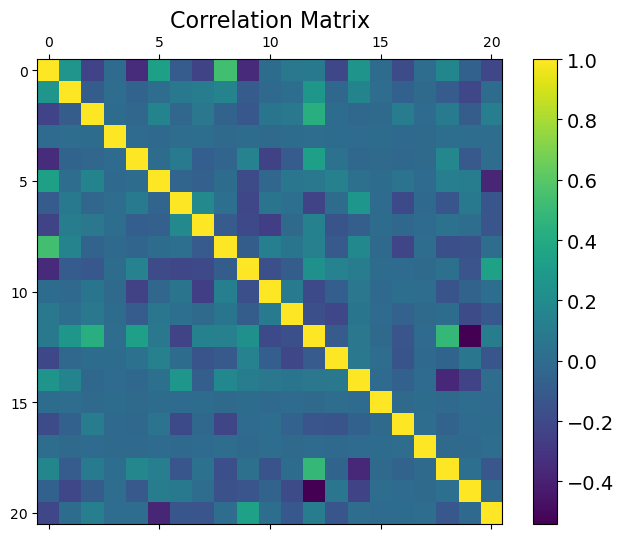

In [19]:
fig = plt.figure(figsize=(8, 6))
plt.matshow( data.corr(), fignum=fig.number )
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [20]:
Y = data["Class"]
X = data.drop("Class", axis=1)
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, Y, train_size=7000, random_state=2)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=1000, random_state=42)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=42)

"Data sizes train: %i, test: %i, calibration: %i, new: %i" % (len(X_train), len(X_test), len(X_calib), len(X_new))

'Data sizes train: 7000, test: 1000, calibration: 1000, new: 1000'

# Train models

## Gaussian Naive Bayes

In [10]:
clf = make_pipeline(StandardScaler(), GaussianNB())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())

model_GaussianNB = clf
model_GaussianNB_acc = (y_pred == y_test).mean()

#cm = confusion_matrix(y_test, y_pred)
#print(pd.DataFrame(cm, index=range(5), columns=range(5)))

Accuracy: 0.777


## SVM

In [11]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

model_SVM = clf
model_SVM_acc = (y_pred == y_test).mean()

print("Accuracy:", model_SVM_acc )

Accuracy: 0.979


In [12]:
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, index=range(5), columns=range(5)))

     0    1    2    3    4
0  179    0    2    3    2
1    1  213    3    0    0
2    0    0  194    0    0
3    3    0    2  191    3
4    0    1    0    1  202


## Random forest

In [13]:
# meta parameter grid search
path = "models/meta_parameters/meta_param_random_forest.json"
if exists(path):
    with open(path, 'r') as f:
        best_params = json.load(f)
else:
    params = {
        "n_estimators" : [10,50,100, 500, 1000],
        "max_depth" : [None, 1, 2, 5, 10],
        "min_samples_split" : [2, 5, 10],
        "min_samples_leaf" : [1, 2, 4],
    }
    model = RandomForestClassifier()
    random_search = RandomizedSearchCV(
        estimator=model, param_distributions=params, cv=5,
        n_iter=10, random_state=0)
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    
    with open(path, 'w') as json_file:
        json.dump(best_params, json_file)
    

print(best_params)

KeyboardInterrupt: 

In [ ]:
clf = make_pipeline(StandardScaler(), 
              RandomForestClassifier(
    **best_params, random_state=1))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

model_randomForest = clf
model_randomForest_acc = (y_pred == y_test).mean()

print("Accuracy:", model_randomForest )

## AdaBoost

In [ ]:
# meta parameter grid search
path = "models/meta_parameters/meta_param_adaBoost.json"
if exists(path):
    with open(path, 'r') as f:
        best_params = json.load(f)
else:
    params = {
        "n_estimators" : [50, 100],
        "learning_rate" : [0.1, 0.2, 0.5, 1],
    }
    model = AdaBoostClassifier()
    random_search = RandomizedSearchCV(
        estimator=model, param_distributions=params, cv=5,
        n_iter=10, random_state=0)
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    
    with open(path, 'w') as json_file:
        json.dump(best_params, json_file)
    

print(best_params)

In [ ]:
clf = make_pipeline(StandardScaler(), 
              AdaBoostClassifier(
    **best_params, random_state=1))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

model_adaBoost = clf
model_adaBoost_acc = (y_pred == y_test).mean()

print("Accuracy:", (y_pred == y_test).mean() )

## MLP

In [21]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Data preparation

In [22]:
def normalize_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return pd.DataFrame(scaler.transform(data))

# create dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels=None, num_classes=5, transform=None, target_transform=None):
        self.features = features
        self.labels = labels
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = self.features.iloc[idx,:]
        if self.transform:
                features = self.transform(features)
        
        if self.labels is not None:
            label = self.labels.iloc[idx]
            #to one hot
            #on_hot = np.zeros(5)
            #on_hot[label] = 1
        
            if self.target_transform:
                label = self.target_transform(label)
                
            return torch.tensor(features), torch.tensor(label, dtype=torch.long)
        else:
            return torch.tensor(features, dtype=torch.float64)

train_dataset = CustomDataset(features=normalize_data(X_train), labels=y_train)
test_dataset = CustomDataset(features=normalize_data(X_test), labels=y_test)
calib_dataset = CustomDataset(features=normalize_data(X_calib), labels=y_calib)

# create data loader
train_iterator = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_iterator = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
calib_iterator = DataLoader(dataset=calib_dataset, batch_size=1, shuffle=False)

### Create model

In [23]:
class MLP(nn.Module):
    def __init__(self, n_classes, n_features, dropout_prob=0.2):
        super(MLP, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, n_features // 2, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(n_features // 2, n_classes, dtype=torch.float64),
        )
        
        #self.fc1 = nn.Linear(n_features, n_features // 2, dtype=torch.float64)
        #self.fc2 = nn.Linear(n_features // 2, n_classes, dtype=torch.float64)
        #self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        #print(x.dtype)
        x = self.linear_relu_stack(x)
        return F.softmax(x, dim=1)
    
model = MLP(n_classes, n_features)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')
print(model)

The model has 265 trainable parameters
MLP(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=5, bias=True)
  )
)


### Training

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        
        results = []

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            
            results.append(y_pred)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), results

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
if not exists('model_weights.pth'):
    
    best_test_loss = np.inf
    EPOCHS = 5

    best_valid_loss = float('inf')

    for epoch in trange(EPOCHS):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
        test_loss, test_acc, _ = evaluate(model, test_iterator, criterion, device)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), 'model_weights.pth')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')   

else:
    model.load_state_dict(torch.load('model_weights.pth'))

In [28]:
calib_loss, calib_acc, scores = evaluate(model, calib_iterator, criterion, device) 
print(f'\t Test Loss: {calib_loss:.3f} |  Test Acc: {calib_acc*100:.2f}%')  

scores = [i[0]for i in scores]
predictions = [torch.argmax(i) for i in scores]

i = np.random.randint(len(y_calib))
print('%i \t prediction %d \t true_label %d \n' % (i, predictions[i] ,y_calib.iloc[i]), scores[i].numpy().round(4))

Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

	 Test Loss: 0.966 |  Test Acc: 93.80%
815 	 prediction 4 	 true_label 4 
 [0. 0. 0. 0. 1.]


# Conformal

In [ ]:
alpha = 0.05

def class_wise_performance(y_new, y_set, classes):
    df = pd.DataFrame()
    for i in range(len(classes)):
        ynew = y_new.values[y_new.values == i]
        yscore = y_set[y_new.values == i]
        cov = classification_coverage_score(ynew, yscore)
        size = classification_mean_width_score(yscore)
        
        temp_df = pd.DataFrame({
            "class" : [classes[i]],
            "coverage" : [cov],
            "avg. set size" : [size]
        }, index = [i])
        
        df = pd.concat([df, temp_df])
    return(df)

In [ ]:
# Initialize Classifier
mapie_score = MapieClassifier(model_GaussianNB, cv="prefit", method="score")

# Calibration
mapie_score.fit(X_calib, y_calib)

# Prediction step
y_pred, y_set = mapie_score.predict(X_new, alpha=alpha)
# remove alpha-dimension
y_set = np.squeeze(y_set)

In [ ]:
model_GaussianNB